# Predictions on different data quality

## Parameters and model

In [1]:
import sys
sys.path.append('..')

from util.graphs import plot_series
from timeseries.timeseries import StockMarketSeries
from timeseries.enums import SeriesColumn, DeviationSource
from predictions.model import PredictionModel

company_name = "Facebook"
time_series_start = "2017-01-03"
time_series_values = 300
columns = [SeriesColumn.CLOSE]
stock = StockMarketSeries(company_name, time_series_start, time_series_values,
                           weights={SeriesColumn.OPEN: 0.2,
                                    SeriesColumn.CLOSE: 0.2,
                                    SeriesColumn.ADJ_CLOSE: 0.25,
                                    SeriesColumn.HIGH: 0.15,
                                    SeriesColumn.LOW: 0.15,
                                    SeriesColumn.VOLUME: 0.05})

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Data - one price column

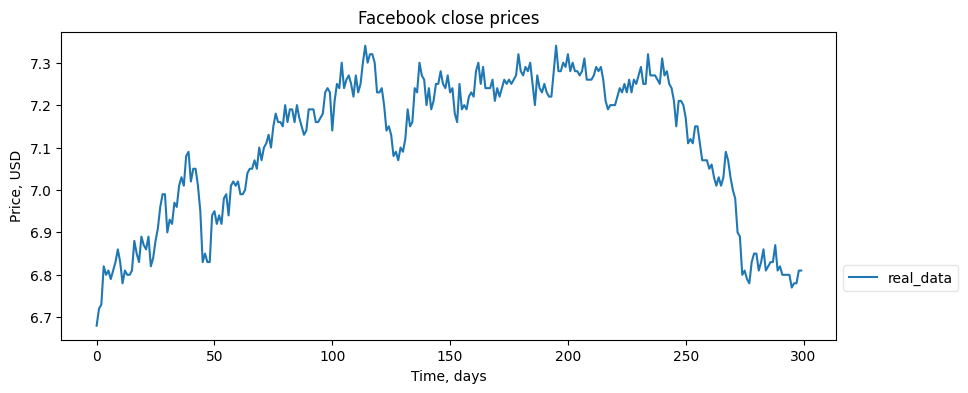

In [2]:
plot_series(stock, "close prices", real_data=stock.real_series[SeriesColumn.CLOSE])

## Predictions parameters

In [3]:
prediction_start = 280
iterations = 5

model = PredictionModel(stock, prediction_start, columns, iterations=iterations)

## Statistical methods

In [4]:
from normal.stats import AutoArima
from normal.stats import Ces

## ARIMA(p,d,q)

In [5]:
arima = model.configure_model(AutoArima)

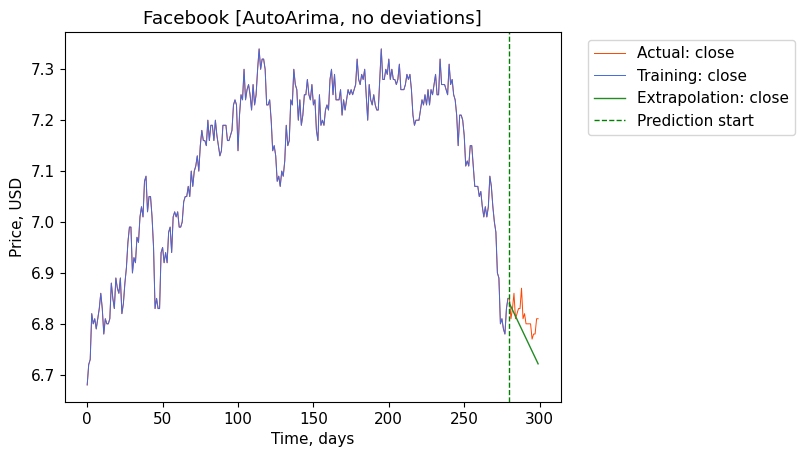

In [6]:
%%capture --no-stdout --no-display
arima.plot_prediction(source=DeviationSource.NONE)

In [7]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Facebook stock, close prices, 5 iterations]

    Num. Dev. Scale Improve             Time [ms]  Time SD  M. time  RMSE   MAE  MAPE
0      1    -     -       N  1.59 + 102.54 + 0.61     2.01     0.00  0.04  0.04  0.54
1      2    N     S       N  1.59 + 102.04 + 0.60     1.31     0.00  0.03  0.03  0.38
2      3    N     S       Y  1.73 + 228.76 + 0.66    11.17    26.87  0.05  0.04  0.66
3      4    N     M       N  1.60 + 106.41 + 0.63     3.08     0.00  0.02  0.02  0.23
4      5    N     M       Y  1.67 + 226.65 + 0.71     5.51    26.22  0.03  0.03  0.37
5      6    N     H       N   1.60 + 64.99 + 0.60     1.92     0.00  0.04  0.04  0.54
6      7    N     H       Y   1.50 + 64.11 + 0.53     0.54    26.33  0.03  0.03  0.43
7      8    I     S       N   1.58 + 99.90 + 0.57     1.15     0.00  0.04  0.04  0.55
8      9    I     S       Y  1.50 + 102.02 + 0.55     1.69     0.33  0.04  0.03  0.48
9     10    I     M       N  1.67 + 101.07 + 0.68     1.78     0.00  0.06  0.06  0.

## CES

In [8]:
ces = model.configure_model(Ces)

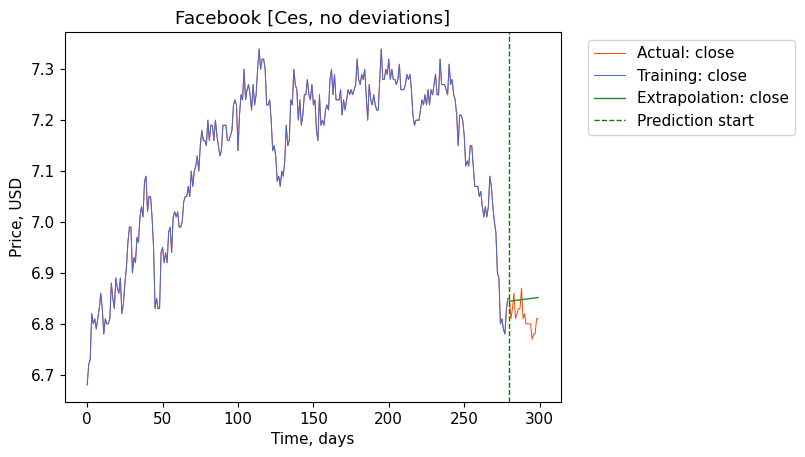

In [9]:
%%capture --no-stdout --no-display
ces.plot_prediction(source=DeviationSource.NONE)

In [10]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Facebook stock, close prices, 5 iterations]

    Num. Dev. Scale Improve           Time [ms]  Time SD  M. time  RMSE   MAE  MAPE
0      1    -     -       N  2.22 + 7.66 + 0.79     2.56     0.00  0.04  0.04  0.56
1      2    N     S       N  2.03 + 8.34 + 0.81     2.08     0.00  0.05  0.04  0.59
2      3    N     S       Y  1.80 + 8.31 + 0.76     0.14    26.87  0.03  0.03  0.43
3      4    N     M       N  1.82 + 8.72 + 0.75     0.97     0.00  0.05  0.04  0.59
4      5    N     M       Y  1.67 + 6.60 + 0.64     0.06    26.22  0.03  0.03  0.41
5      6    N     H       N  1.57 + 6.73 + 0.58     0.68     0.00  0.05  0.04  0.60
6      7    N     H       Y  1.50 + 8.37 + 0.53     0.26    26.33  0.04  0.03  0.45
7      8    I     S       N  1.45 + 5.38 + 0.48     0.18     0.00  0.04  0.04  0.57
8      9    I     S       Y  1.43 + 5.77 + 0.47     0.23     0.33  0.04  0.04  0.56
9     10    I     M       N  1.39 + 5.21 + 0.46     0.18     0.00  0.04  0.03  0.50
10    11    I     M

## XGBoost

In [11]:
from normal.ml import XGBoost

xgboost = model.configure_model(XGBoost, optimize=False)

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\utils.py:109: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(series.values, "r", label=f"Actual: {column.value}", linewidth='0.7', color=colors[i % len(colors)])
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\utils.py:117: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(series, "b", label=f"Training: {column.value}", linewidth='0.7', color=colors[i % len(

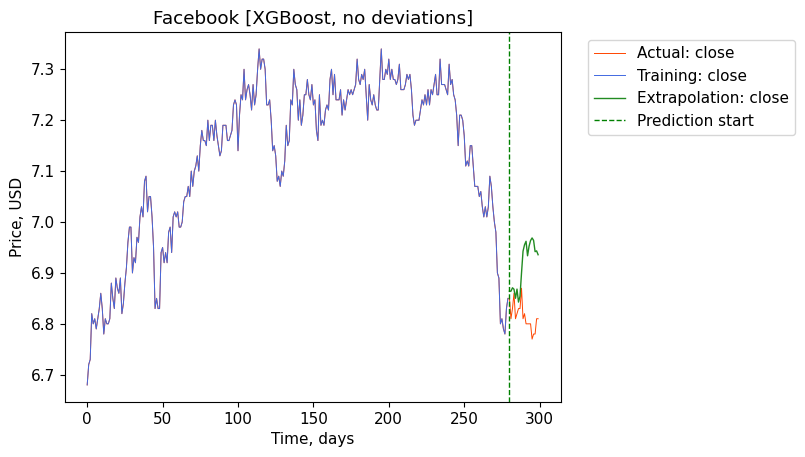

In [12]:
xgboost.plot_prediction(source=DeviationSource.NONE)

In [13]:
%%capture --no-stdout --no-display
xgboost.compute_statistics_set()

Statistics [Facebook stock, close prices, 5 iterations]

    Num. Dev. Scale Improve              Time [ms]  Time SD  M. time  RMSE   MAE  MAPE
0      1    -     -       N   2.42 + 32.95 + 88.82     3.76     0.00  0.12  0.10  1.44
1      2    N     S       N   2.66 + 37.85 + 99.53     5.65     0.00  0.11  0.09  1.30
2      3    N     S       Y   2.48 + 27.69 + 94.65    13.16    26.87  0.05  0.04  0.66
3      4    N     M       N  2.61 + 35.46 + 102.72    18.61     0.00  0.07  0.06  0.83
4      5    N     M       Y   2.70 + 31.22 + 97.40    14.94    26.22  0.03  0.02  0.36
5      6    N     H       N   2.81 + 34.87 + 94.59     5.25     0.00  0.05  0.05  0.69
6      7    N     H       Y  2.65 + 29.91 + 100.24    12.60    26.33  0.04  0.04  0.52
7      8    I     S       N   2.63 + 34.31 + 96.61     5.57     0.00  0.06  0.05  0.70
8      9    I     S       Y   2.73 + 34.72 + 95.65     5.41     0.33  0.11  0.09  1.30
9     10    I     M       N  2.73 + 36.80 + 103.58     9.02     0.00  0.1

## Reservoir computing

In [14]:
from predictions.normal.nn import Reservoir

reservoir = model.configure_model(Reservoir)

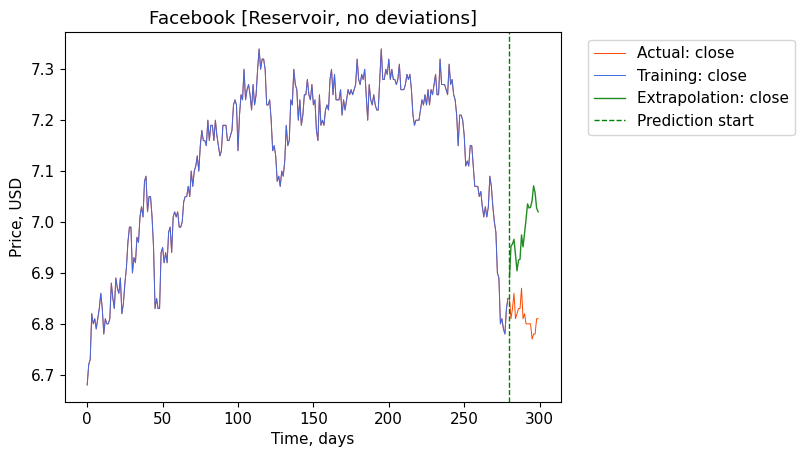

In [15]:
reservoir.plot_prediction(source=DeviationSource.NONE)

In [16]:
%%capture --no-stdout --no-display
reservoir.compute_statistics_set()

Statistics [Facebook stock, close prices, 5 iterations]

    Num. Dev. Scale Improve             Time [ms]  Time SD  M. time  RMSE   MAE  MAPE
0      1    -     -       N  0.24 + 183.98 + 1.43     1.31     0.00  0.18  0.17  2.49
1      2    N     S       N  0.24 + 185.80 + 1.41     2.09     0.00  0.16  0.15  2.23
2      3    N     S       Y  0.24 + 186.24 + 1.47     1.85    26.87  0.08  0.07  1.04
3      4    N     M       N  0.25 + 184.90 + 1.38     3.10     0.00  0.22  0.20  2.90
4      5    N     M       Y  0.24 + 185.85 + 1.40     2.38    26.22  0.11  0.09  1.31
5      6    N     H       N  0.24 + 186.04 + 1.43     2.00     0.00  0.29  0.26  3.87
6      7    N     H       Y  0.26 + 186.52 + 1.54     4.41    26.33  0.19  0.16  2.33
7      8    I     S       N  0.24 + 193.51 + 1.46     1.82     0.00  0.31  0.29  4.23
8      9    I     S       Y  0.24 + 185.81 + 1.43     2.27     0.33  0.21  0.19  2.83
9     10    I     M       N  0.21 + 183.99 + 1.49     1.72     0.00  0.03  0.03  0.